In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [5]:
# Load the CSV files
file_path_1 = '/kaggle/input/train-dataset/loan_train_dataset.csv'

train_data = pd.read_csv(file_path_1)

train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
# Remove the Loan_ID column because it is useless
train_data.drop(columns=['Loan_ID'], inplace=True)

Understand the data more with correlation matrix

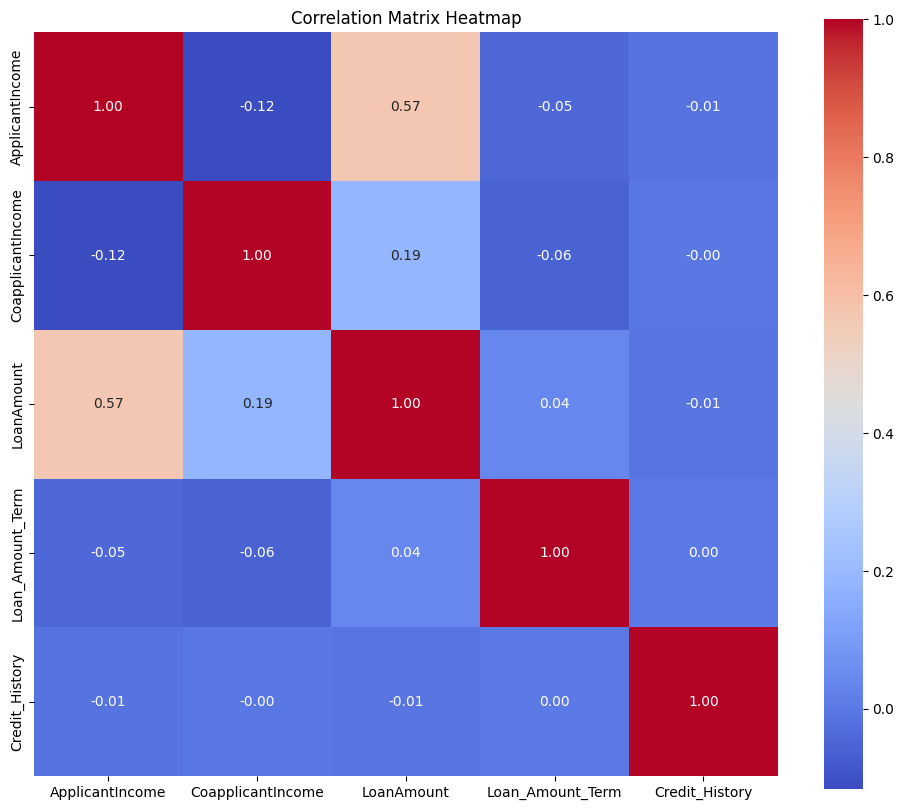

In [7]:
# Detailed Correlation Visualization
# Correlation matrix
numerical_data = train_data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

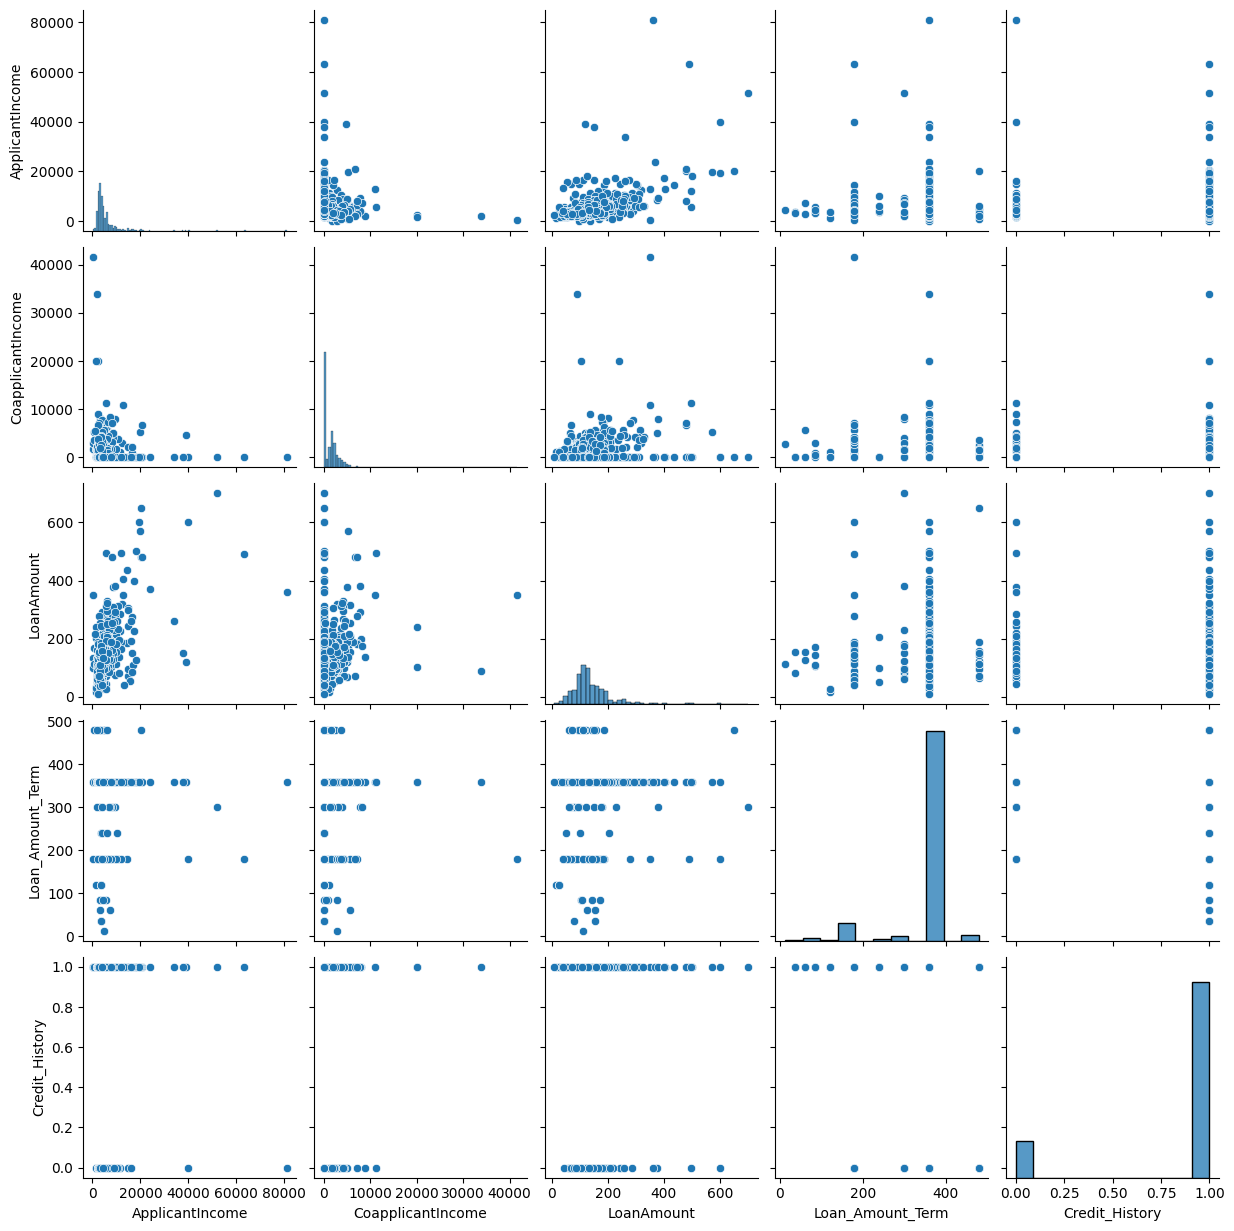

In [8]:
sns.pairplot(numerical_data)
plt.show()

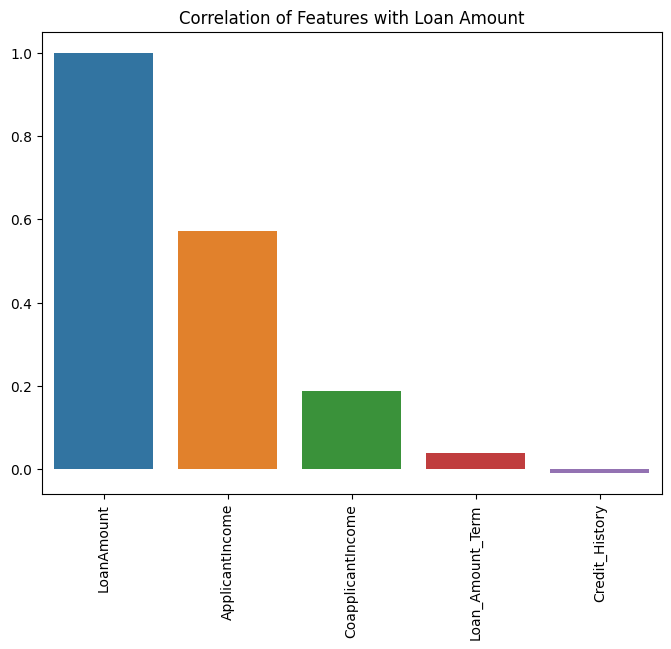

In [9]:
plt.figure(figsize=(8, 6))
correlation_with_target = numerical_data.corr()['LoanAmount'].sort_values(ascending=False)
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.xticks(rotation=90)
plt.title('Correlation of Features with Loan Amount')
plt.show()

Features like ApplicantIncome and CoapplicantIncome have a positive correlation with LoanAmount.

Next will check the data set to see if it needs any cleaning (duplicates, missing values, spliting categories, ...)

In [10]:
# Checking for missing values in training data
missing_train = train_data.isnull().sum()

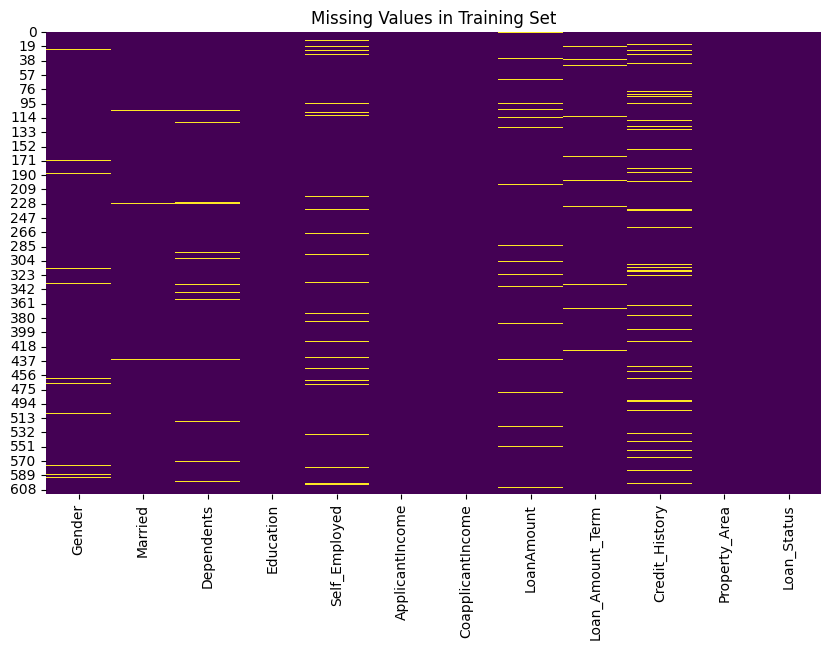

In [11]:
# Visualizing missing values in training data
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Training Set')
plt.show()

In [12]:
missing_percentage = train_data.isnull().mean() * 100
missing_percentage

Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [13]:
#will fill missing values instead of dropping them
for column in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    train_data[column].fillna(train_data[column].mode()[0], inplace=True)


# Filling missing numerical values with median
train_data['LoanAmount'].fillna(train_data['LoanAmount'].median(), inplace=True)
train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].median(), inplace=True)


/tmp/ipykernel_33/3844934284.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[column].fillna(train_data[column].mode()[0], inplace=True)
/tmp/ipykernel_33/3844934284.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [14]:
#we don't have any duplicates after handling missing values
duplicates = train_data.duplicated().sum()
print(f"Duplicate rows in training set: {duplicates}")

Duplicate rows in training set: 0


Lets have some more visualizations to understand the data more

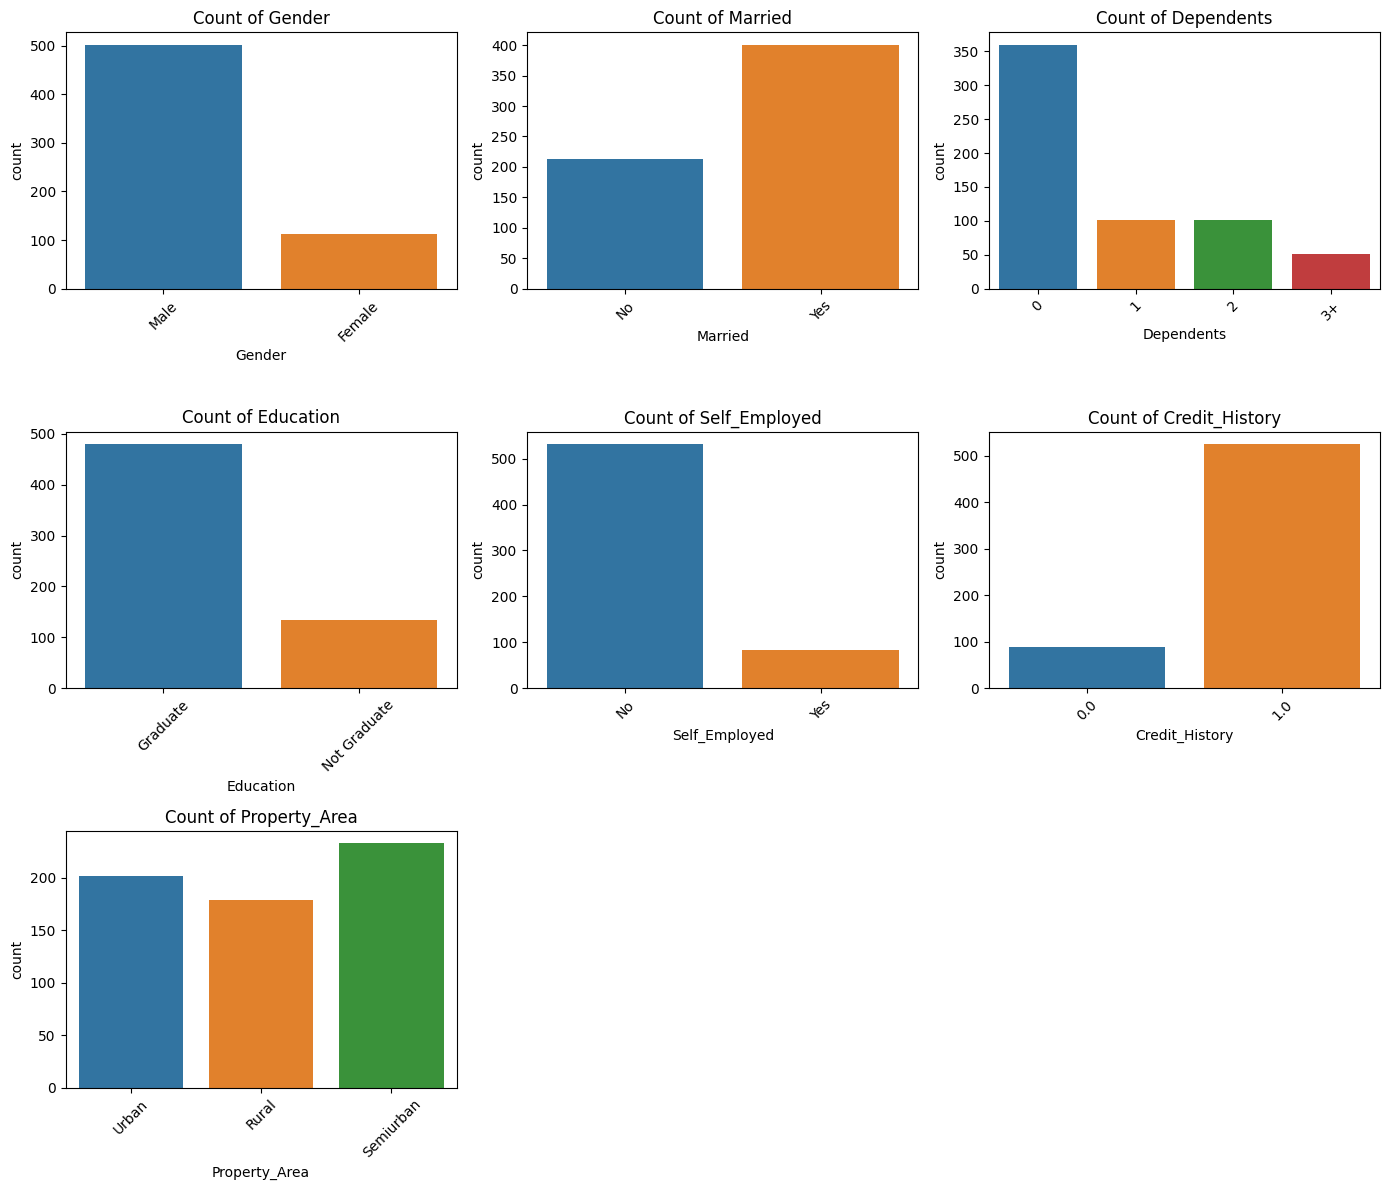

In [15]:
# Count plots for categorical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

plt.figure(figsize=(14, 12))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=train_data, x=feature)
    plt.title(f'Count of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

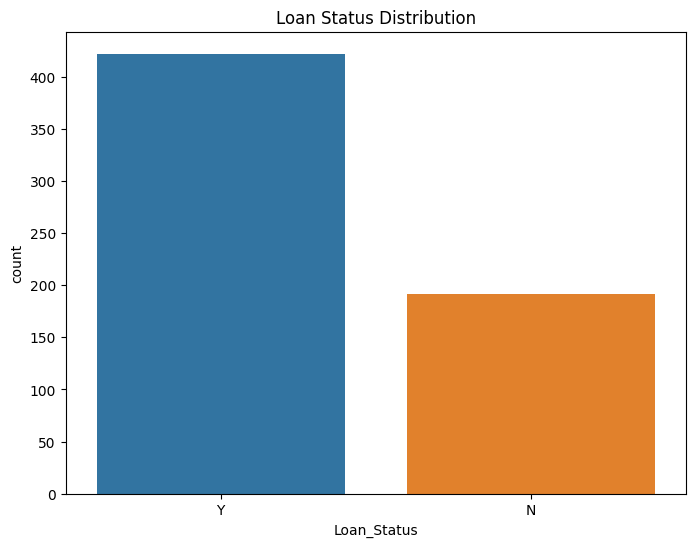

In [16]:
# Loan Status Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='Loan_Status')
plt.title('Loan Status Distribution')
plt.show()

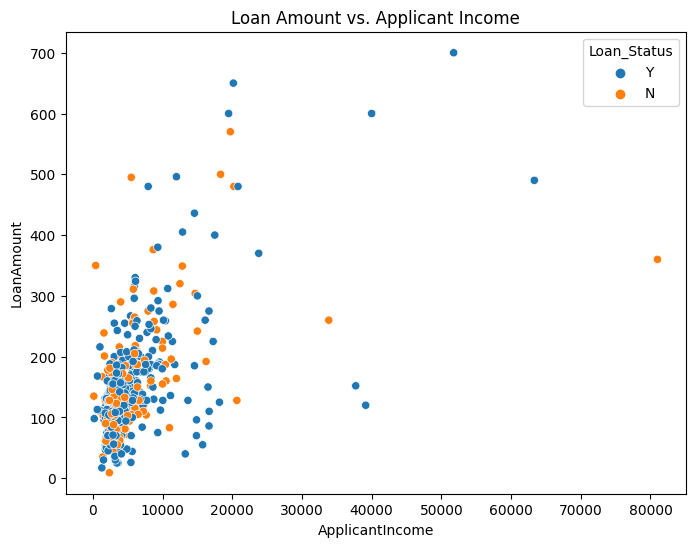

In [17]:
# Loan Amount vs. Applicant Income
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data, x='ApplicantIncome', y='LoanAmount', hue='Loan_Status')
plt.title('Loan Amount vs. Applicant Income')
plt.show()

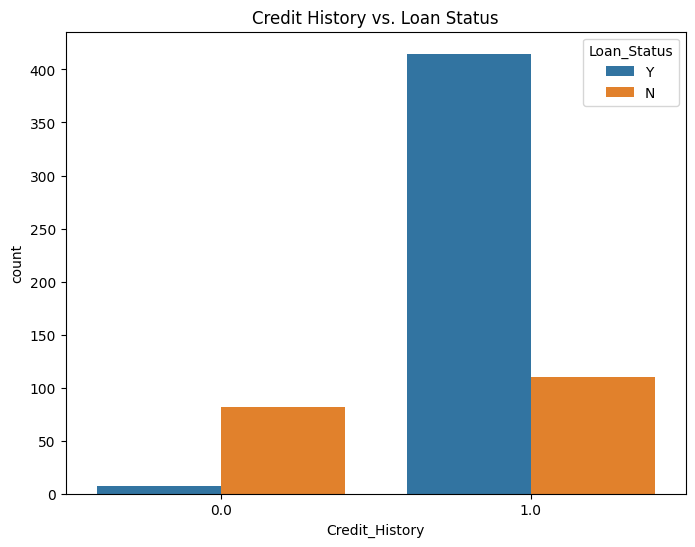

In [18]:
# Credit History vs. Loan Status
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='Credit_History', hue='Loan_Status')
plt.title('Credit History vs. Loan Status')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

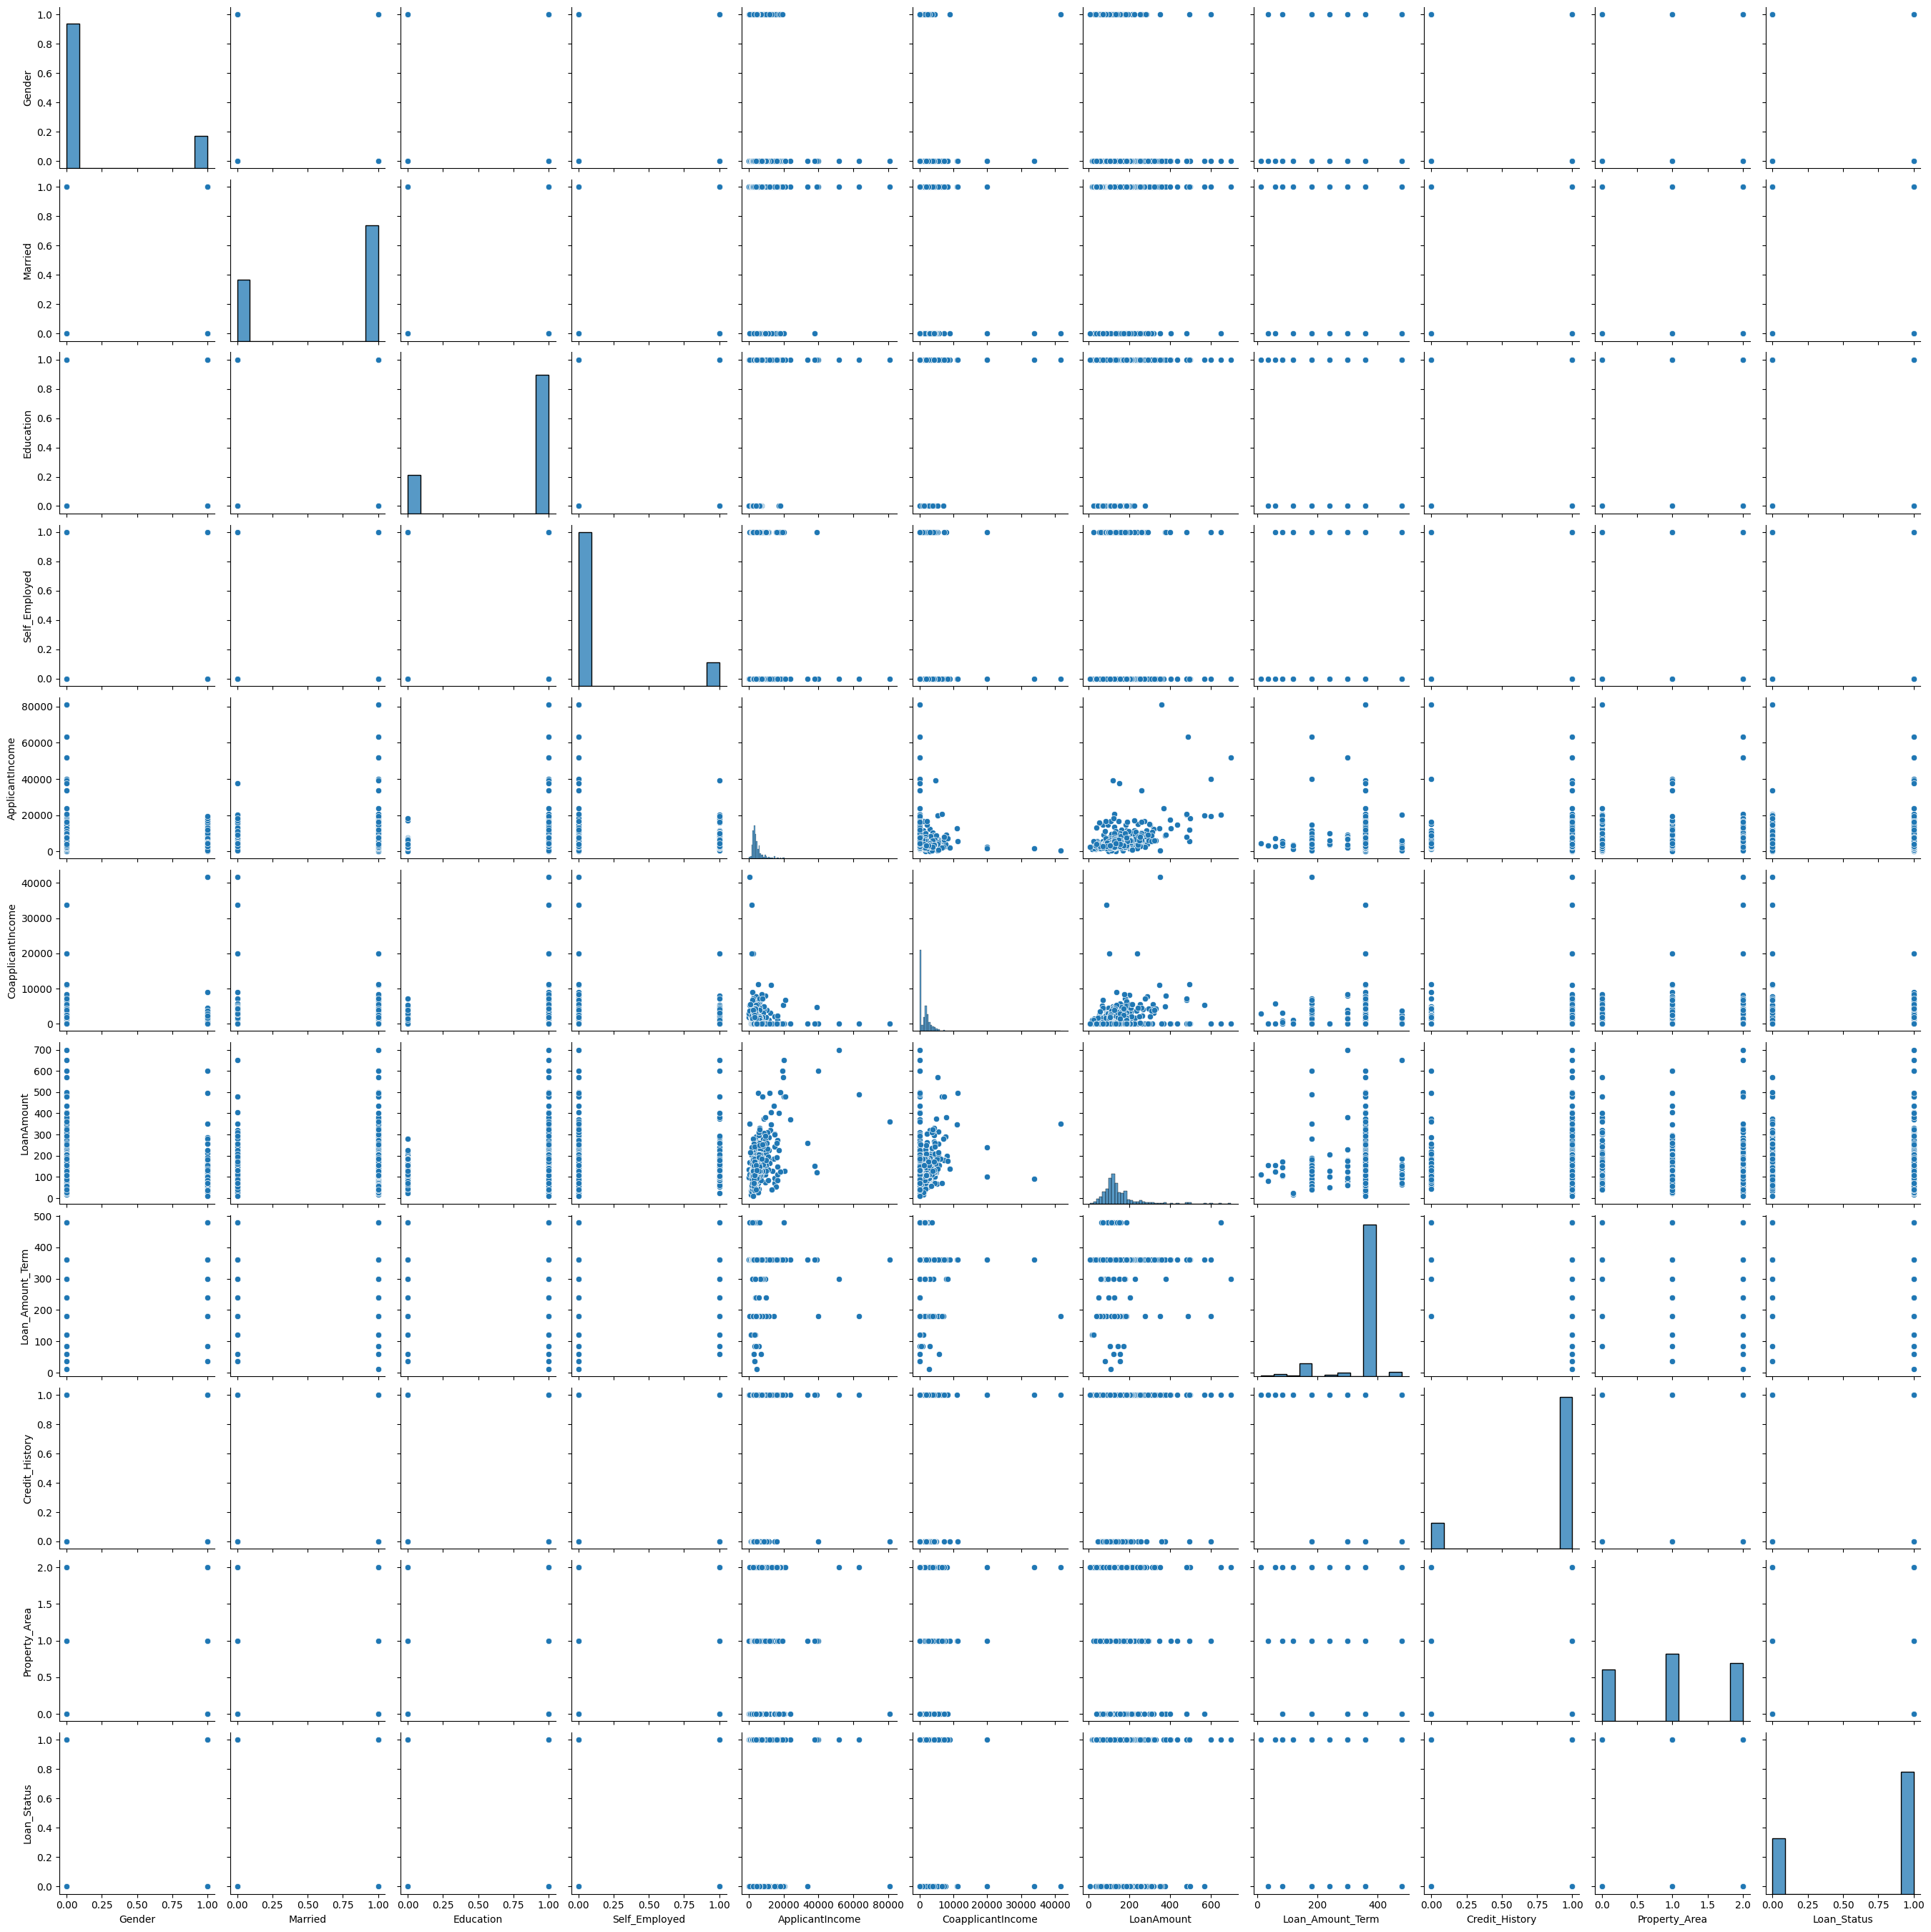

In [19]:
# Pair plot for all features
# Encode categorical features before plotting
encoded_data = train_data.copy()
encoded_data['Gender'] = encoded_data['Gender'].map({'Male': 0, 'Female': 1})
encoded_data['Married'] = encoded_data['Married'].map({'No': 0, 'Yes': 1})
encoded_data['Education'] = encoded_data['Education'].map({'Not Graduate': 0, 'Graduate': 1})
encoded_data['Self_Employed'] = encoded_data['Self_Employed'].map({'No': 0, 'Yes': 1})
encoded_data['Loan_Status'] = encoded_data['Loan_Status'].map({'N': 0, 'Y': 1})
encoded_data['Property_Area'] = encoded_data['Property_Area'].map({'Rural': 0, 'Semiurban': 1, 'Urban': 2})

sns.pairplot(encoded_data)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

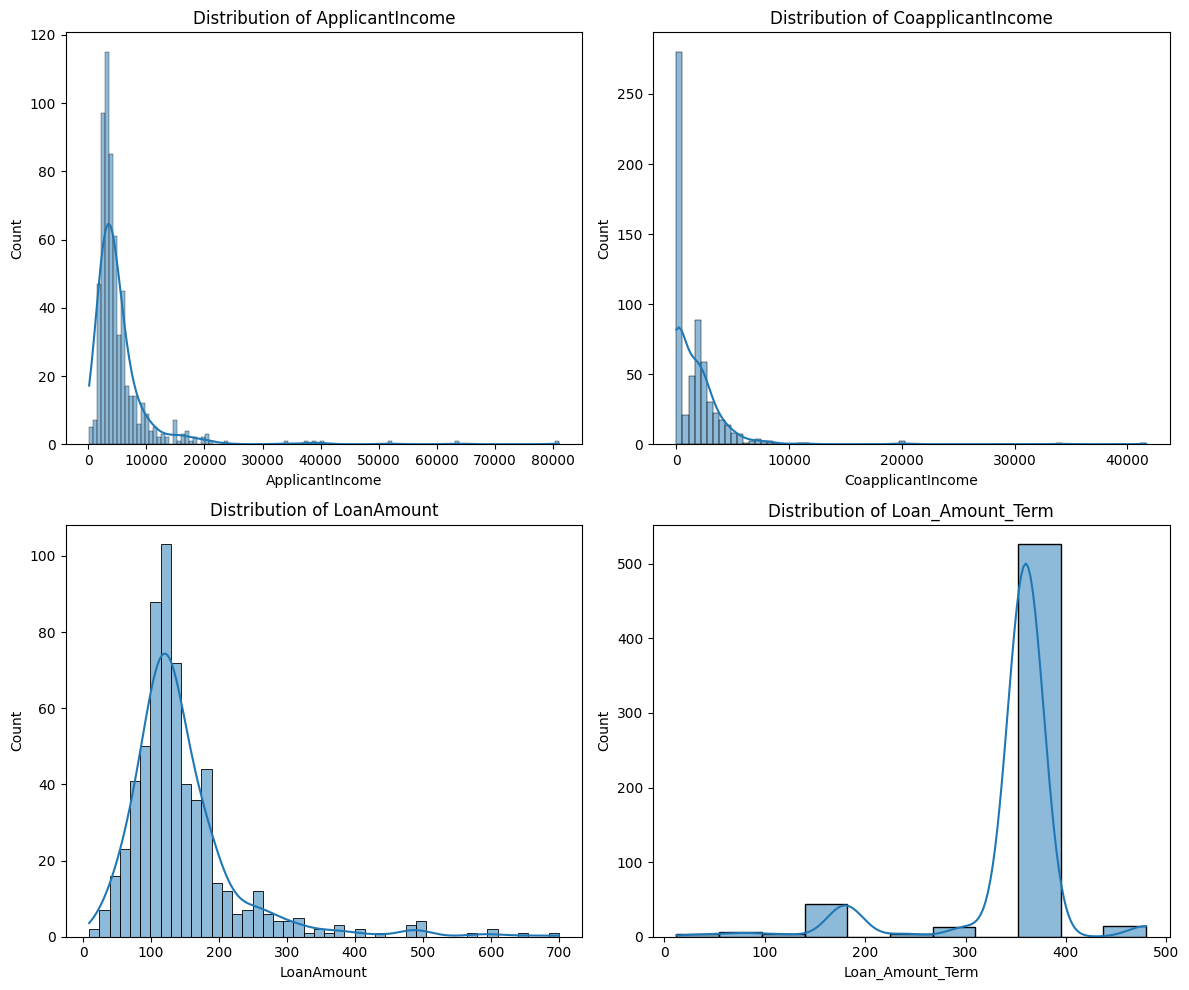

In [20]:
# Distribution plots for numerical features
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


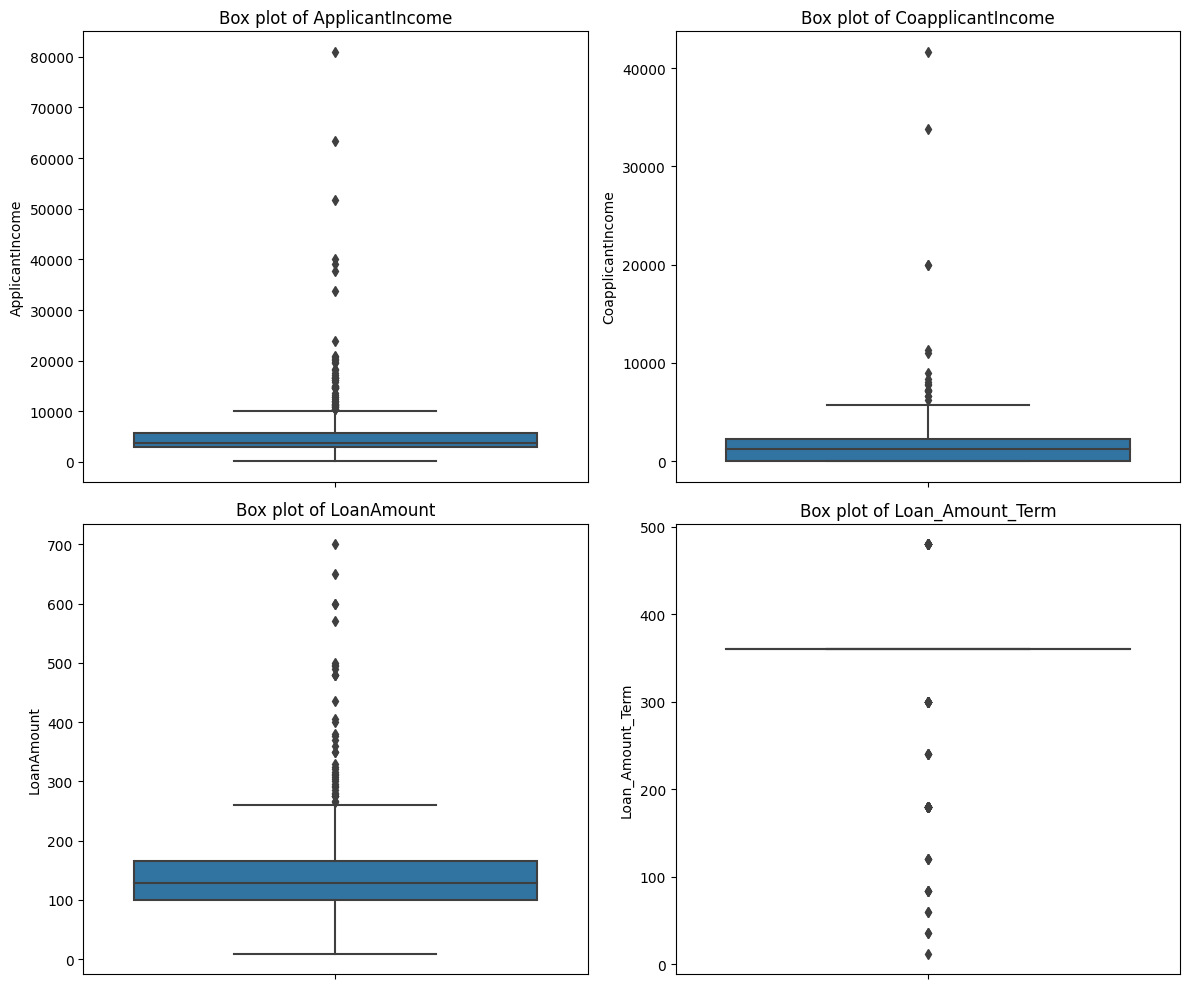

In [21]:
# Box plots for numerical features
plt.figure(figsize=(12, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=train_data[feature])
    plt.title(f'Box plot of {feature}')
plt.tight_layout()
plt.show()


Overall Conclusions

Income and Loan Amounts: Higher income levels correlate with higher loan amounts and higher approval rates.
Credit History: Positive credit history significantly impacts loan approval chances.
Outliers: Presence of outliers in income and loan amount data suggests the need for handling them in preprocessing.
Categorical Features: Imbalances in categorical features like Gender and Self_Employed may need attention.
Loan Approval Factors: Factors like income, credit history, and property area play crucial roles in loan approval, which can guide feature selection and engineering for predictive modeling.proval, which can guide feature selection and engineering for predictive modeling.

In [22]:
# Function to cap outliers
def cap_outliers(series, lower_percentile=0.01, upper_percentile=0.99):
    lower_limit = series.quantile(lower_percentile)
    upper_limit = series.quantile(upper_percentile)
    return series.clip(lower=lower_limit, upper=upper_limit)

# Apply capping on numerical features
for feature in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    train_data[feature] = cap_outliers(train_data[feature])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


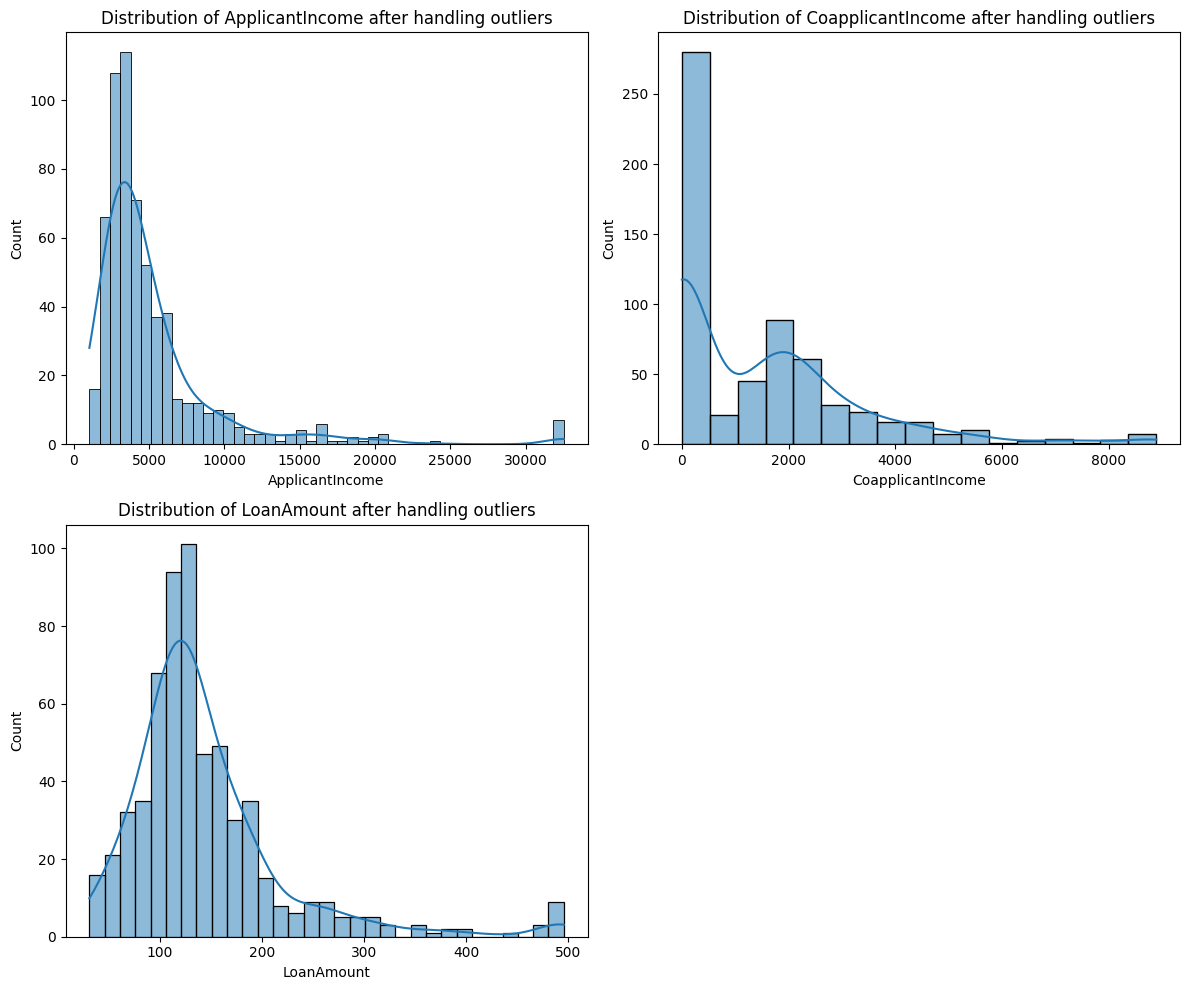

In [23]:
# Visualizing distributions of numerical features after handling outliers
plt.figure(figsize=(12, 10))
for i, feature in enumerate(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature} after handling outliers')
plt.tight_layout()
plt.show()

The distributions are now less skewed compared to the original data, with reduced extreme values.

In [24]:
# Summary statistics after handling outliers
print("Summary Statistics for Training Dataset after handling outliers:")
print(train_data.describe())

Summary Statistics for Training Dataset after handling outliers:
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  614.000000        614.000000   
mean       5214.577964        1483.654967  144.787687        342.410423   
std        4528.770082        1831.226927   78.513474         64.428629   
min        1025.000000           0.000000   30.650000         12.000000   
25%        2877.500000           0.000000  100.250000        360.000000   
50%        3812.500000        1188.500000  128.000000        360.000000   
75%        5795.000000        2297.250000  164.750000        360.000000   
max       32540.410000        8895.890000  495.870000        480.000000   

       Credit_History  
count      614.000000  
mean         0.855049  
std          0.352339  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


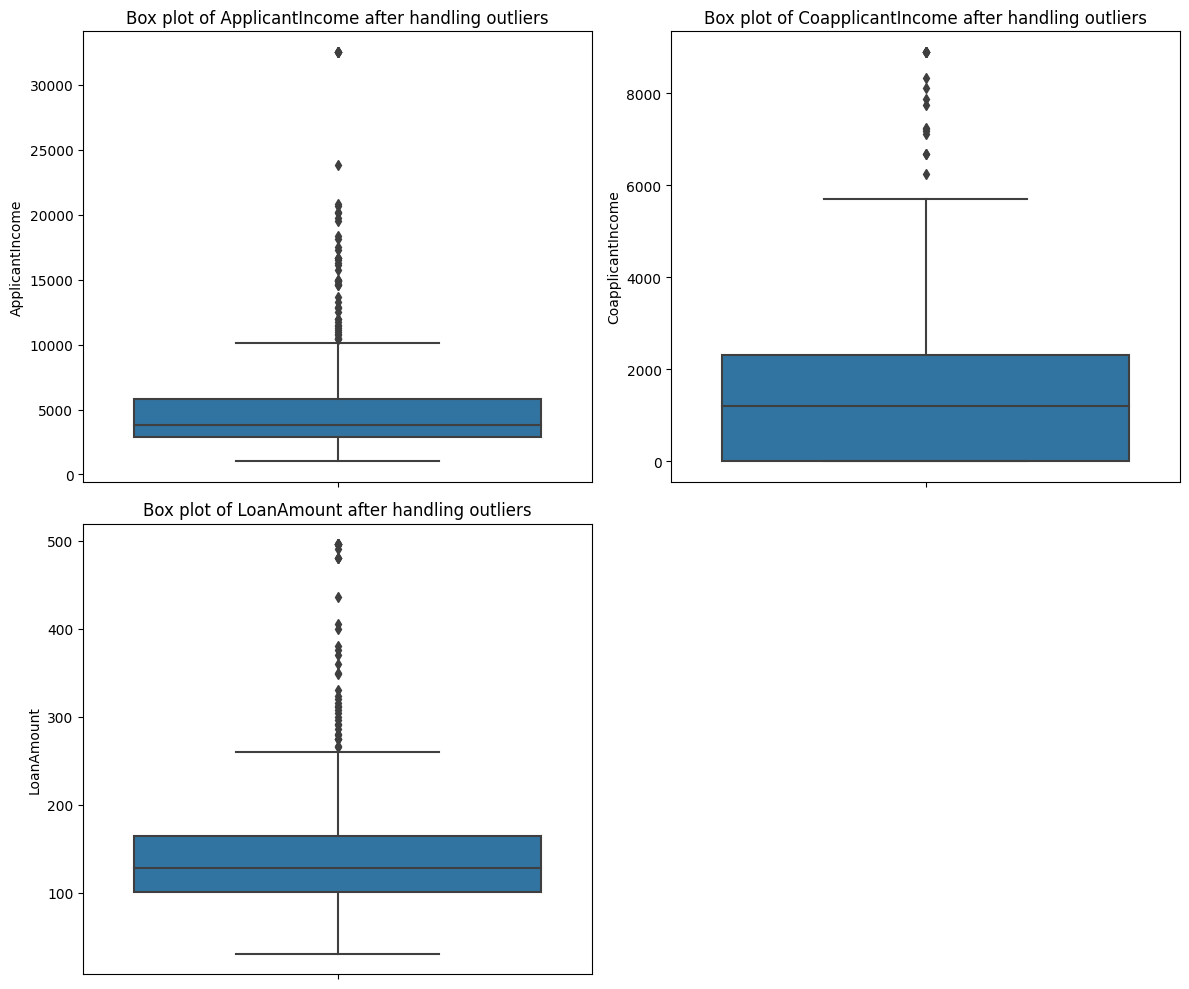

In [25]:
# Box plots for numerical features after handling outliers
plt.figure(figsize=(12, 10))
for i, feature in enumerate(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=train_data[feature])
    plt.title(f'Box plot of {feature} after handling outliers')
plt.tight_layout()
plt.show()

Outliers have been capped, resulting in box plots with fewer extreme points.

Will start preparing the dataset for DT,NN and regression

In [28]:
# Separate features and target
X = train_data.drop(columns=['Loan_Status'])
y = train_data['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Handle categorical variables
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create a ColumnTransformer to apply one-hot encoding to categorical columns and standard scaling to numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)


In [29]:
# Train a Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Evaluate the Decision Tree model
y_pred_tree = decision_tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
tree_confusion_matrix = confusion_matrix(y_test, y_pred_tree)
tree_classification_report = classification_report(y_test, y_pred_tree)
print("Decision Tree Accuracy:", tree_accuracy)
print("Decision Tree Confusion Matrix:\n", tree_confusion_matrix)
print("Decision Tree Classification Report:\n", tree_classification_report)

Decision Tree Accuracy: 0.7297297297297297
Decision Tree Confusion Matrix:
 [[ 33  32]
 [ 18 102]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.51      0.57        65
           1       0.76      0.85      0.80       120

    accuracy                           0.73       185
   macro avg       0.70      0.68      0.69       185
weighted avg       0.72      0.73      0.72       185



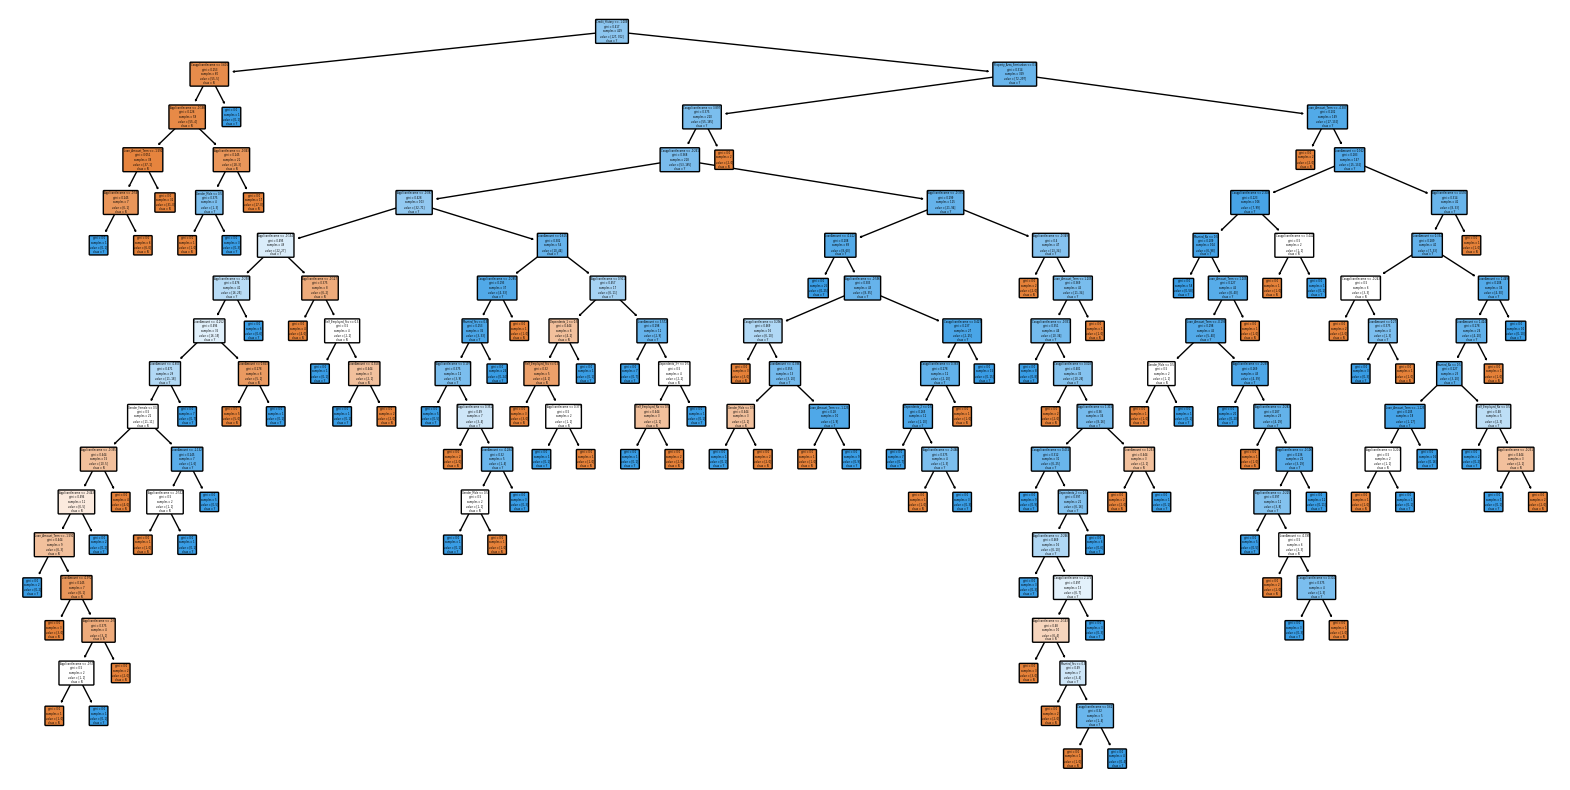

In [41]:
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, filled=True, feature_names=feature_names, class_names=['N', 'Y'], rounded=True)
plt.show()

In [30]:
# Build the Neural Network model
neural_network_model = Sequential()
neural_network_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(32, activation='relu'))
neural_network_model.add(Dense(1, activation='sigmoid'))

# Compile the model
neural_network_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = neural_network_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Evaluate the Neural Network model
nn_loss, nn_accuracy = neural_network_model.evaluate(X_test, y_test, verbose=0)
y_pred_nn = (neural_network_model.predict(X_test) > 0.5).astype("int32")
nn_confusion_matrix = confusion_matrix(y_test, y_pred_nn)
nn_classification_report = classification_report(y_test, y_pred_nn)
print("Neural Network Accuracy:", nn_accuracy)
print("Neural Network Confusion Matrix:\n", nn_confusion_matrix)
print("Neural Network Classification Report:\n", nn_classification_report)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 - 2s - 126ms/step - accuracy: 0.6527 - loss: 0.6718 - val_accuracy: 0.6541 - val_loss: 0.6276
Epoch 2/50
14/14 - 0s - 6ms/step - accuracy: 0.7156 - loss: 0.6105 - val_accuracy: 0.7189 - val_loss: 0.5964
Epoch 3/50
14/14 - 0s - 6ms/step - accuracy: 0.7692 - loss: 0.5654 - val_accuracy: 0.7730 - val_loss: 0.5711
Epoch 4/50
14/14 - 0s - 10ms/step - accuracy: 0.7646 - loss: 0.5517 - val_accuracy: 0.7838 - val_loss: 0.5495
Epoch 5/50
14/14 - 0s - 6ms/step - accuracy: 0.7925 - loss: 0.5188 - val_accuracy: 0.7838 - val_loss: 0.5391
Epoch 6/50
14/14 - 0s - 10ms/step - accuracy: 0.7995 - loss: 0.5121 - val_accuracy: 0.7838 - val_loss: 0.5383
Epoch 7/50
14/14 - 0s - 10ms/step - accuracy: 0.8205 - loss: 0.4787 - val_accuracy: 0.7838 - val_loss: 0.5296
Epoch 8/50
14/14 - 0s - 8ms/step - accuracy: 0.8182 - loss: 0.4687 - val_accuracy: 0.7838 - val_loss: 0.5254
Epoch 9/50
14/14 - 0s - 13ms/step - accuracy: 0.8065 - loss: 0.4744 - val_accuracy: 0.7838 - val_loss: 0.5327
Epoch 10/50
1

In [31]:
# Compare their performance
print("Comparison of Models")
print("====================")
print("Decision Tree Accuracy:", tree_accuracy)
print("Neural Network Accuracy:", nn_accuracy)
print("\nDecision Tree Confusion Matrix:\n", tree_confusion_matrix)
print("\nNeural Network Confusion Matrix:\n", nn_confusion_matrix)
print("\nDecision Tree Classification Report:\n", tree_classification_report)
print("\nNeural Network Classification Report:\n", nn_classification_report)

Comparison of Models
Decision Tree Accuracy: 0.7297297297297297
Neural Network Accuracy: 0.7945945858955383

Decision Tree Confusion Matrix:
 [[ 33  32]
 [ 18 102]]

Neural Network Confusion Matrix:
 [[ 29  36]
 [  2 118]]

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.51      0.57        65
           1       0.76      0.85      0.80       120

    accuracy                           0.73       185
   macro avg       0.70      0.68      0.69       185
weighted avg       0.72      0.73      0.72       185


Neural Network Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.45      0.60        65
           1       0.77      0.98      0.86       120

    accuracy                           0.79       185
   macro avg       0.85      0.71      0.73       185
weighted avg       0.83      0.79      0.77       185



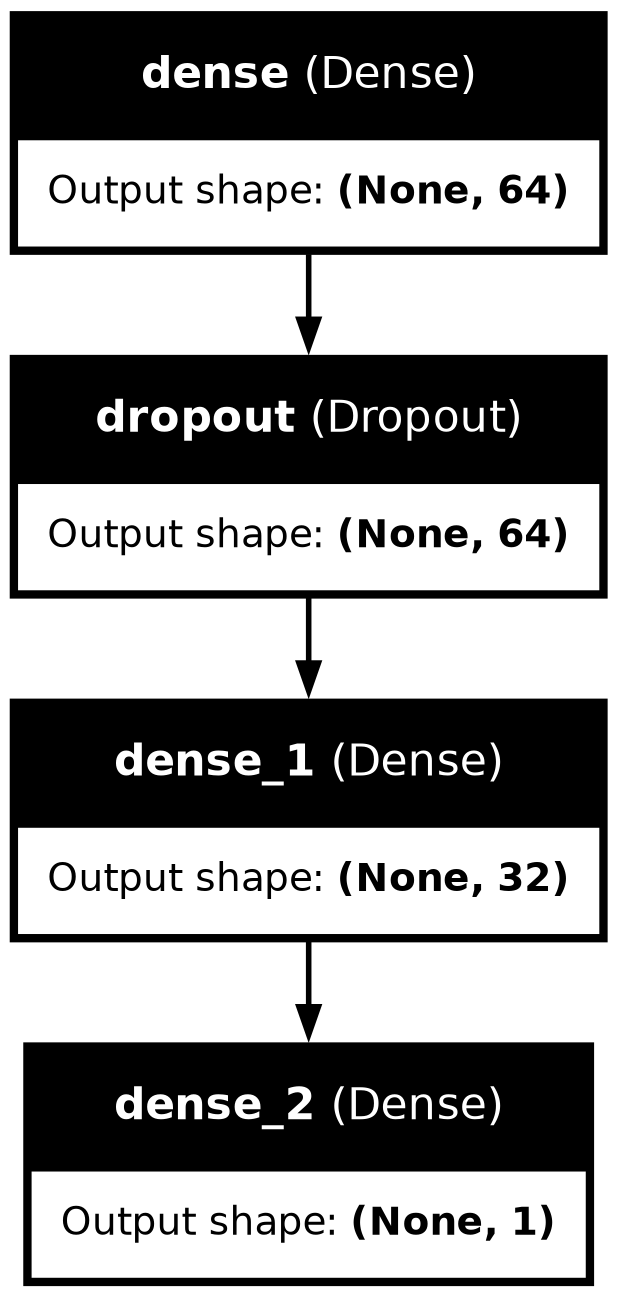

In [37]:
plot_model(neural_network_model, to_file='neural_network_model.png', show_shapes=True, show_layer_names=True)

**For Class 0 (Loan Rejected):**

The Neural Network has a much higher precision (0.94) compared to the Decision Tree (0.65), meaning it is better at correctly identifying rejected loans.
However, the recall is lower for the Neural Network (0.45) compared to the Decision Tree (0.51), indicating that it misses more rejected loans.

**For Class 1 (Loan Approved):**

The Neural Network performs better in both precision (0.77 vs. 0.76) and recall (0.98 vs. 0.85), meaning it is better at correctly identifying approved loans and missing fewer approved loans.

**Interpretability:**

The Decision Tree is more interpretable, making it easier to understand the decision-making process. This can be crucial in scenarios where transparency is important.

**Performance:**

The Neural Network outperforms the Decision Tree in terms of accuracy and F1-Score, making it a better choice for achieving the highest possible performance.

